In [1]:
#Importing Neccassary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statistics import mean
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from string import punctuation
from keras.models import Sequential,Model
from keras.layers import Embedding,Input,Activation,Flatten,CuDNNLSTM,Dense,Dropout,Bidirectional,LSTM,MaxPool1D
from keras.layers import Convolution1D,GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import gc
%matplotlib inline
tqdm.pandas()

In [2]:
#Mounting google drive to access files
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Loading Train and Validation datasets
train_data = pd.read_csv("/content/drive/My Drive/train.csv")
validation_dataset = pd.read_csv("/content/drive/My Drive/test.csv")

#Accessing CSV for saving results.
result = pd.read_csv("/content/drive/My Drive/predictions.csv") 

##Exploratory Data Analysis

In [4]:
#First 5 rows of the dataset
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
#Copying train_data to variable df
df = train_data.copy()
df.shape #indicates number of attributes and rows in the dataset

(1804874, 45)

In [6]:
#Description of the dataset
print(df.describe())

                 id        target  severe_toxicity       obscene  \
count  1.804874e+06  1.804874e+06     1.804874e+06  1.804874e+06   
mean   3.738434e+06  1.030173e-01     4.582099e-03  1.387721e-02   
std    2.445187e+06  1.970757e-01     2.286128e-02  6.460419e-02   
min    5.984800e+04  0.000000e+00     0.000000e+00  0.000000e+00   
25%    7.969752e+05  0.000000e+00     0.000000e+00  0.000000e+00   
50%    5.223774e+06  0.000000e+00     0.000000e+00  0.000000e+00   
75%    5.769854e+06  1.666667e-01     0.000000e+00  0.000000e+00   
max    6.334010e+06  1.000000e+00     1.000000e+00  1.000000e+00   

       identity_attack        insult        threat          asian  \
count     1.804874e+06  1.804874e+06  1.804874e+06  405130.000000   
mean      2.263571e-02  8.115273e-02  9.311271e-03       0.011964   
std       7.873156e-02  1.760657e-01  4.942218e-02       0.087166   
min       0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%       0.000000e+00  0.000000e+00  0.00

In [7]:
#Creating a new coloumn with labels "Toxic" & "Non-Toxic" based on the value of the 'target' coloumn
new_df = df.copy()
new_df['Nature of Comments'] = np.where(new_df['target'] >= .5, 'Toxic', 'Non-Toxic')

In [8]:
#Creating a dataframe with Nature of Comments and there total count in the entire dataset.
new_df = new_df['Nature of Comments'].value_counts().rename_axis('Nature of Comments').reset_index(name='Number of Comments')
new_df

,Nature of Comments,Number of Comments
0,Non-Toxic,1660540
1,Toxic,144334


In [9]:
#Plotting "Toxic vs Non-Toxic" comments present in the dataset
fig = px.bar(new_df, x="Nature of Comments", y="Number of Comments", color="Nature of Comments", title="Non-Toxic vs Toxic")
fig.show()

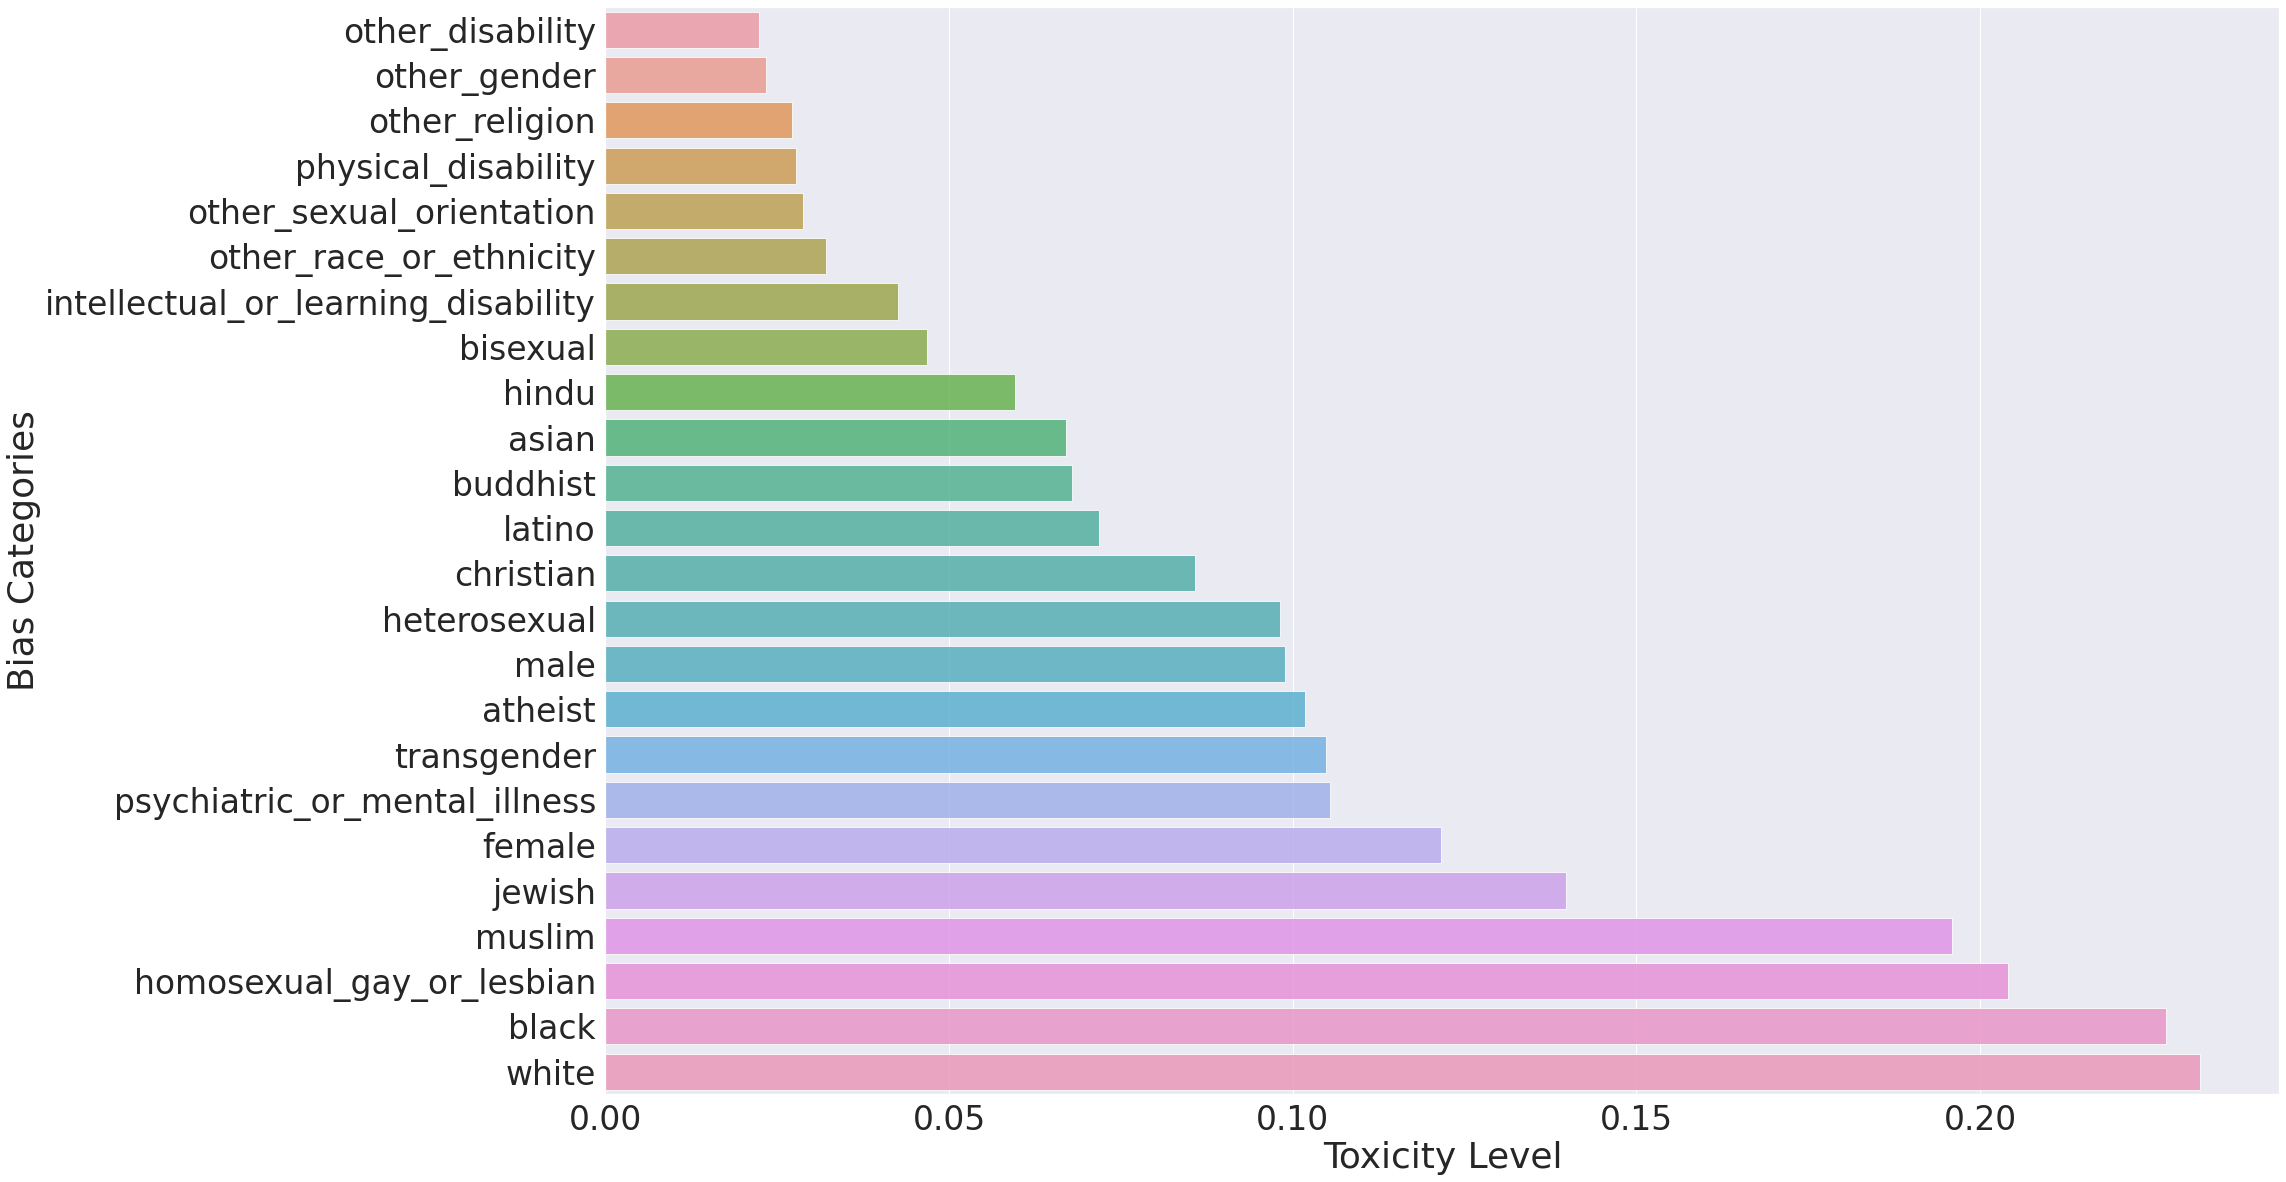

In [10]:
#plotting demographics of toxic comments
demographics = df.loc[:, ['target']+list(df)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=True)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Bias Categories')
plt.xlabel('Toxicity Level')
plt.show()

In [11]:
#Filtering out bias categories and their counts
identities = list(df)[slice(8,32)]
target_identities = ['target']+list(df)[slice(8,32)]
bias_categories = df.loc[:, target_identities].dropna()

toxic_bc = bias_categories[bias_categories['target'] >= .5][identities]
non_toxic_bc = bias_categories[bias_categories['target'] < .5][identities]

toxic_bc_count = toxic_bc.where(bias_categories == 0, other = 1).sum()
non_toxic_bc_count = non_toxic_bc.where(bias_categories == 0, other = 1).sum()

<Figure size 2160x1440 with 0 Axes>

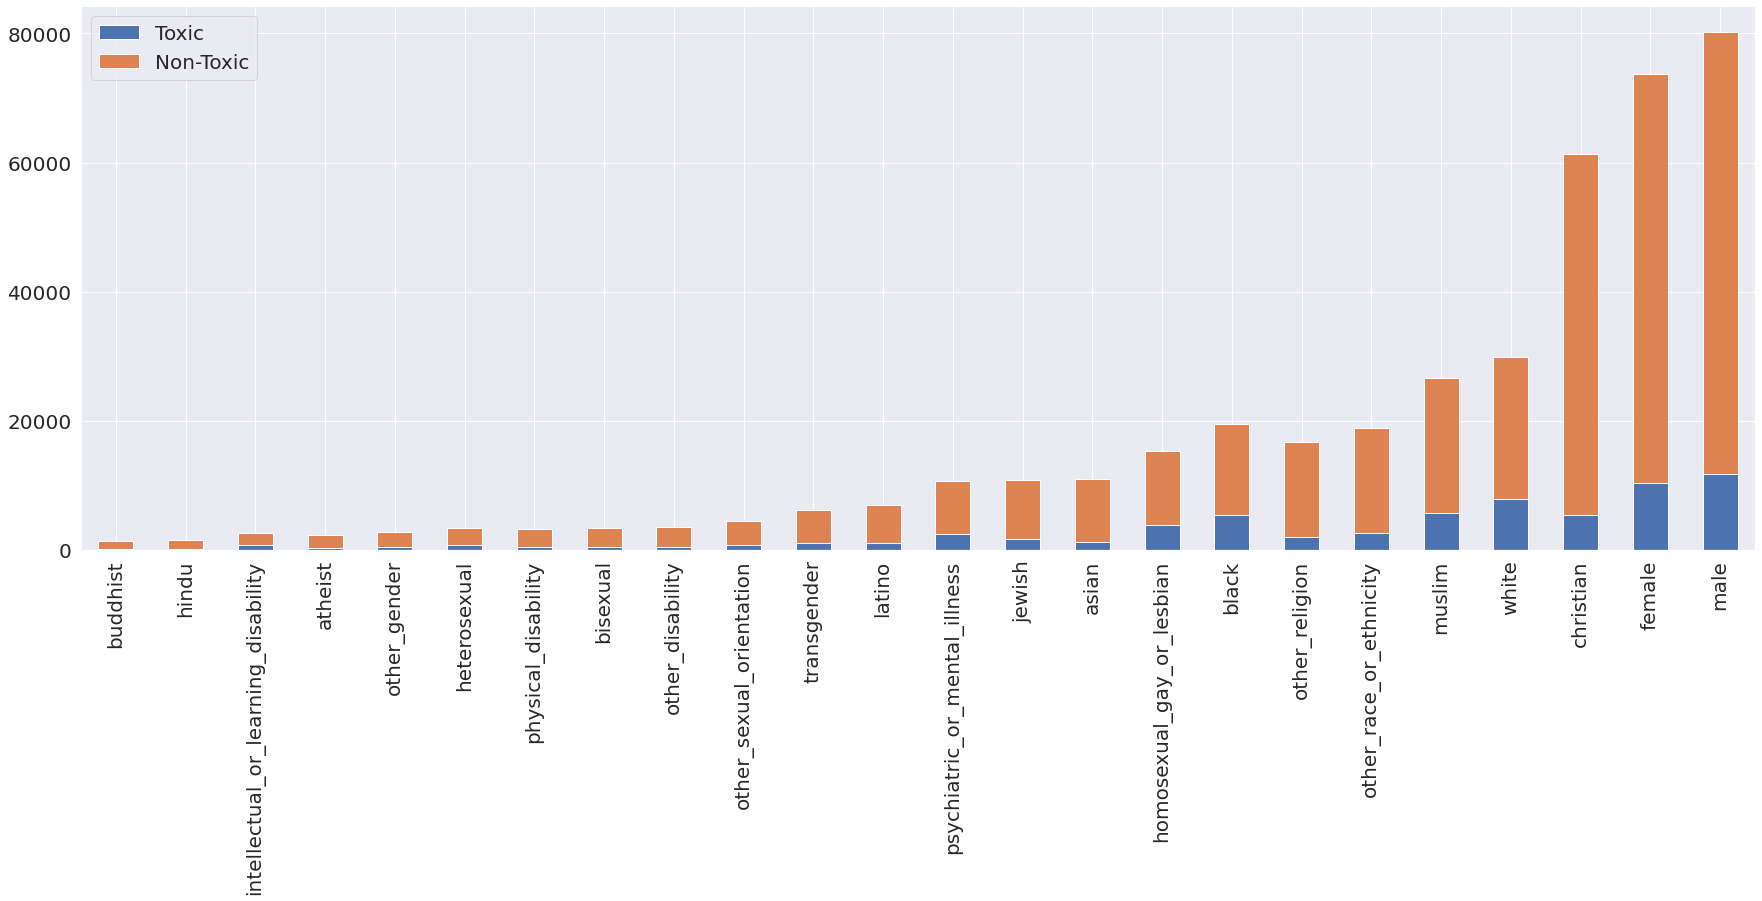

In [12]:
#Plotting number of comments based on various biases
toxic_vs_non_toxic = pd.concat([toxic_bc_count, non_toxic_bc_count], axis=1)
plt.figure(figsize=(30,20))
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "Non-Toxic", 0: "Toxic"})
toxic_vs_non_toxic.sort_values(by='Non-Toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



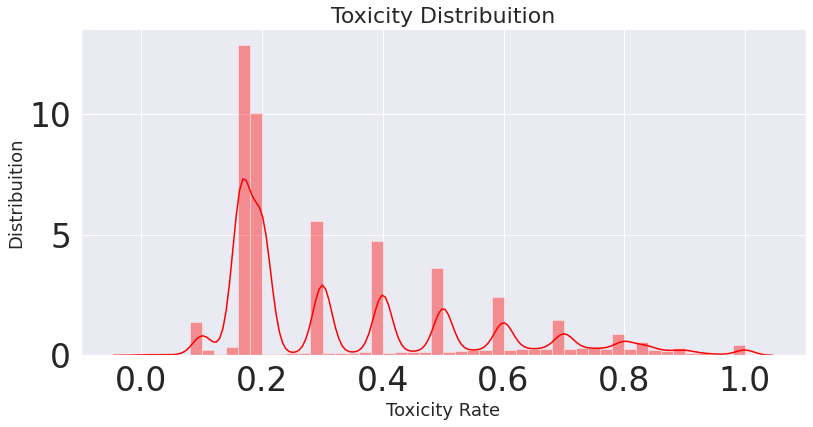

In [13]:
#Plotting distribution of toxicity in comments
plt.figure(figsize=(13,6))
g = sns.distplot(df[df['target'] > 0]['target'], color = 'red')
plt.title('Toxicity Distribuition', fontsize=22)
plt.xlabel("Toxicity Rate", fontsize=18)
plt.ylabel("Distribuition", fontsize=18) 
plt.show()

<AxesSubplot:>

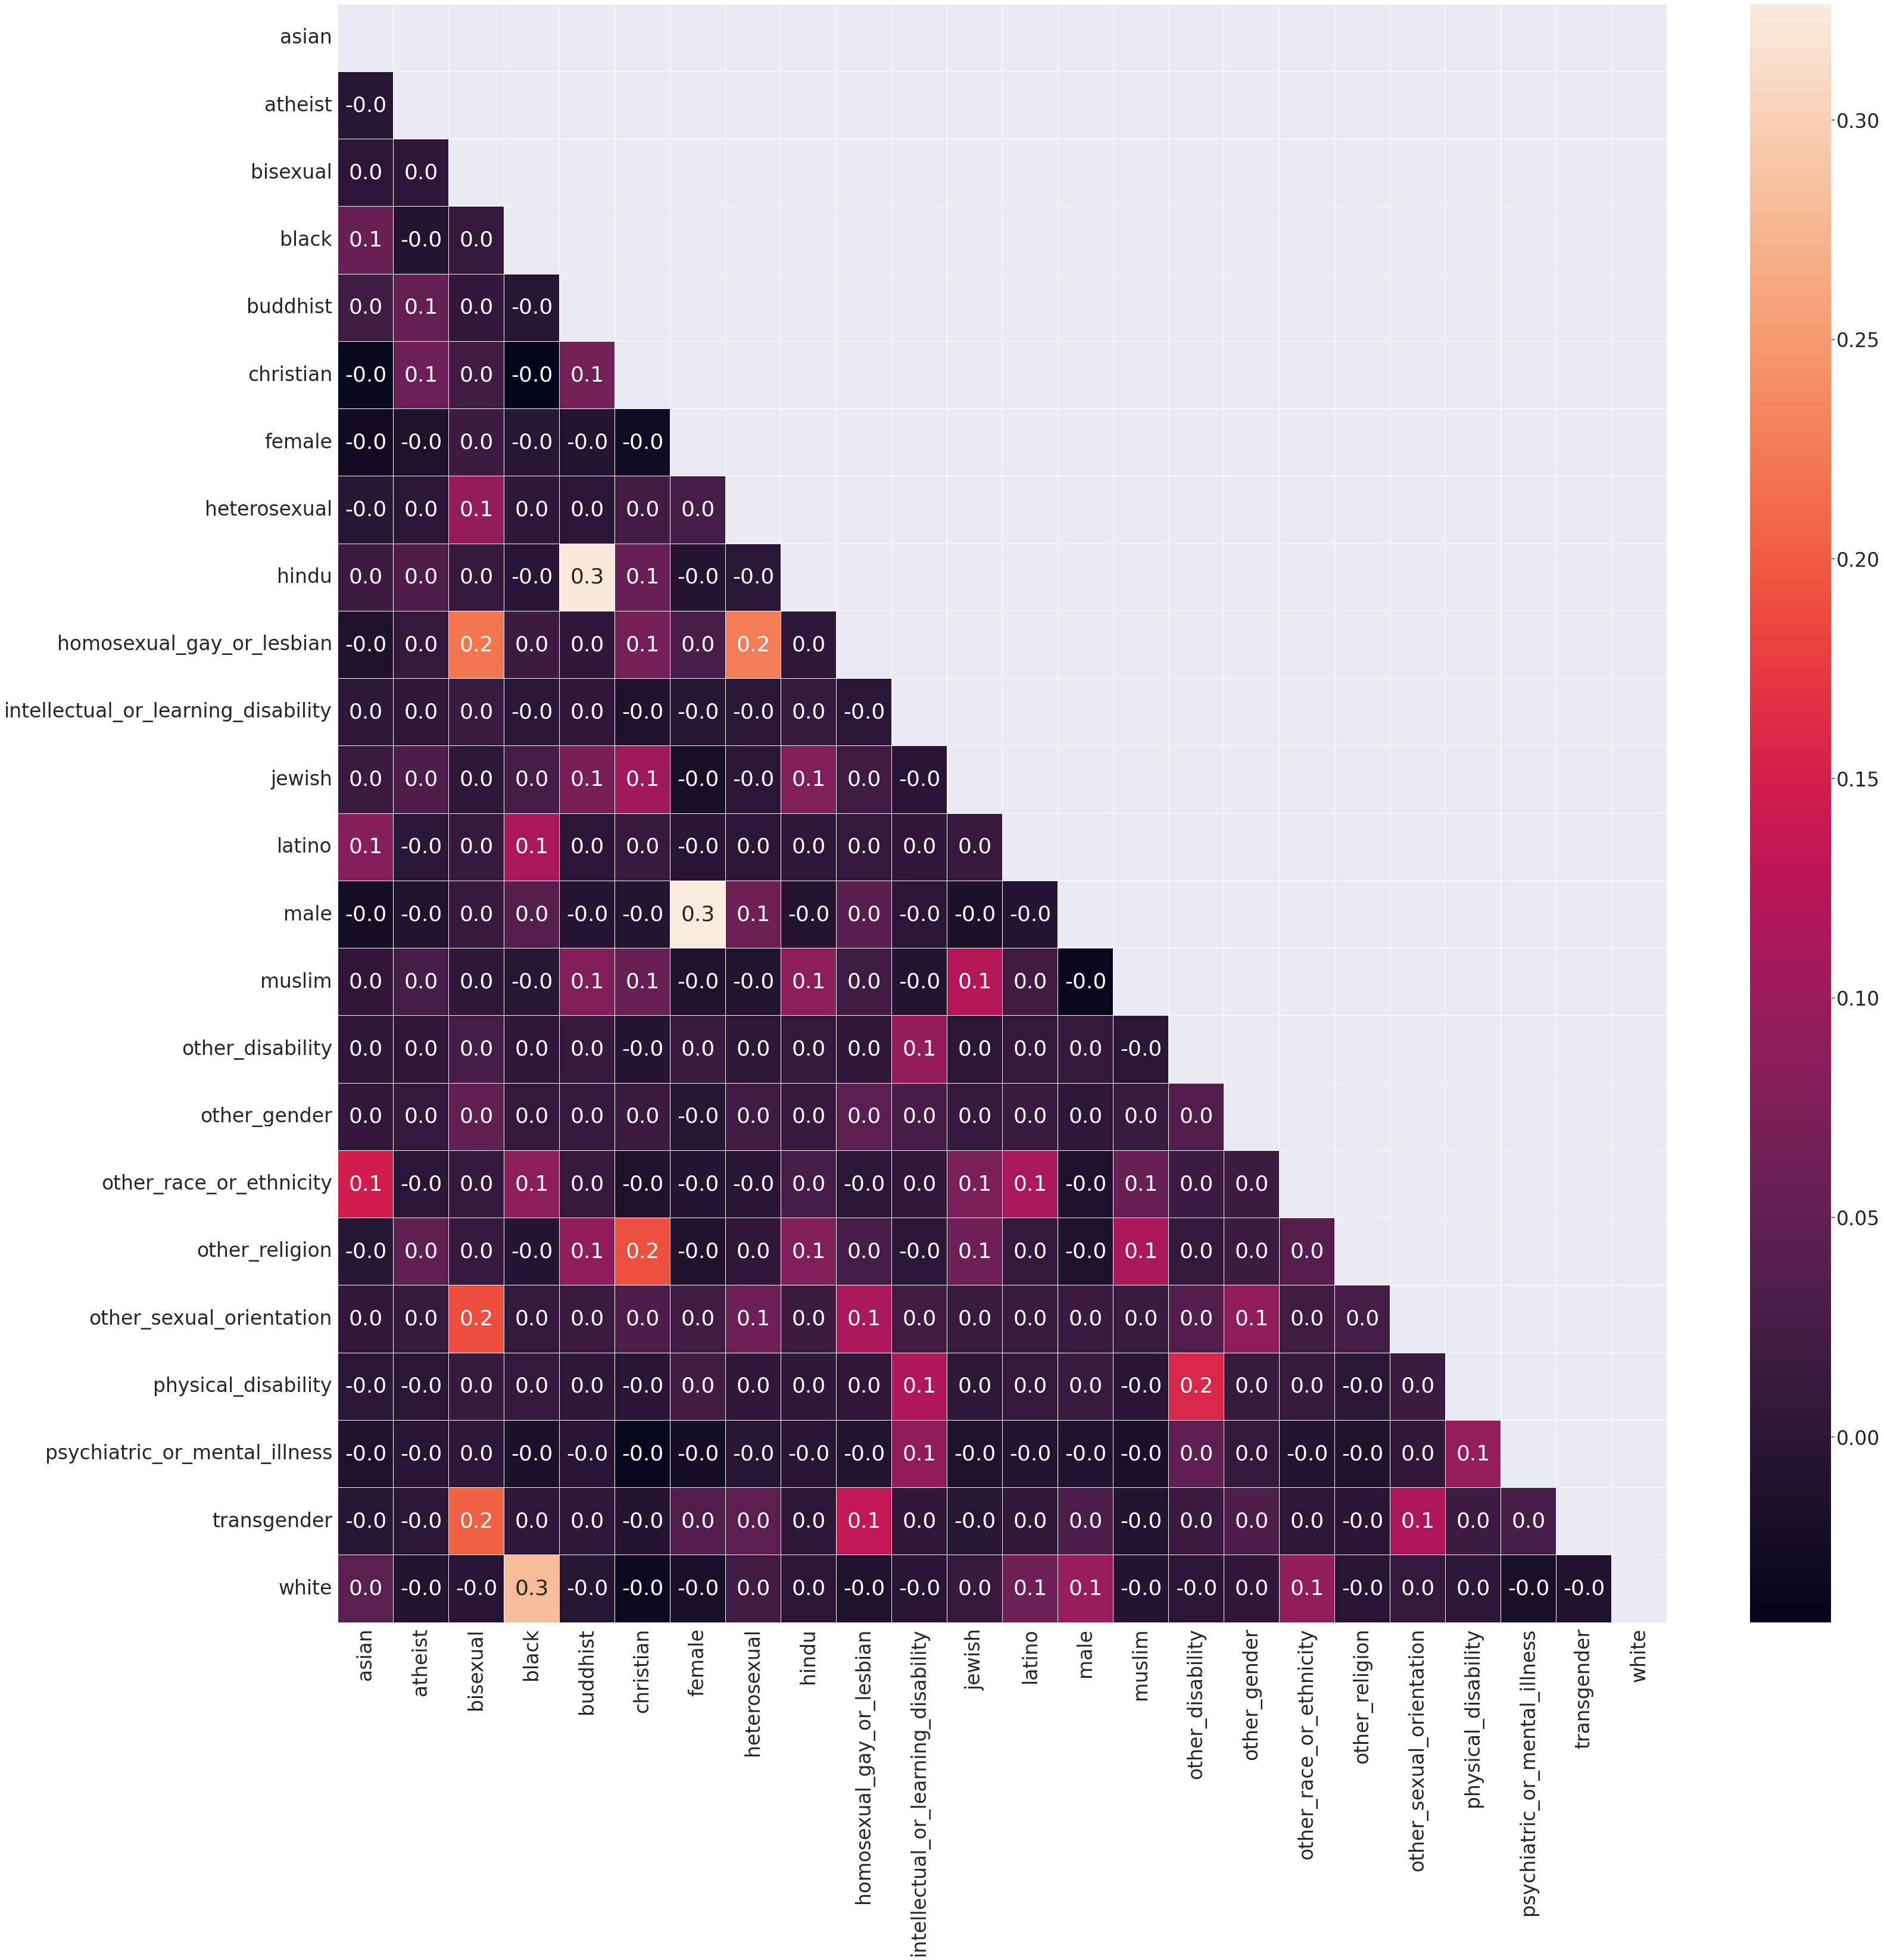

In [14]:
#Plotting Correlation heatmap
x = df.loc[:, identities].dropna()
f, ax = plt.subplots(figsize=(50,50))
matrix = np.triu(x.corr())
sns.heatmap(x.corr(), annot = True, linewidth = 0.8   , fmt = '.1f', ax = ax, mask = matrix)

##Data Preparation

In [15]:
#Transformation of text data into numerical vectors  [1]
vector = TfidfVectorizer()
X_ml = vector.fit_transform(df["comment_text"])
validation_X = vector.transform(validation_dataset["comment_text"])

In [16]:
#assigning target values and saving them to an np array(for  ML models)  [1]
y_ml = np.where(df['target'] >= 0.5, 1, 0)

In [17]:
#number of rows and columns in X_ml and y_ml
X_ml.shape, y_ml.shape

((1804874, 318304), (1804874,))

In [18]:
#Splitting the dataset into train and test datasets for ML models [4]
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

In [19]:
#Deleting X_ml and y_ml to free up memory  [3]
del (X_ml,y_ml)
gc.collect()

7073

In [20]:
#Assigniing target values to column 'target' of input dataframe (for Deep Learning models)  [3]
def target(value):
    if value>=0.5:
        return 1
    else:
        return 0
df['target'] = df['target'].apply(target)

In [21]:
#Assigning X_dl(feature) and y_dl(target)
X_dl = df['comment_text']
y_dl = df['target']

In [22]:
#Function to clean input text by converting all letters into lower cases and removing non alphabetic characters  [3]
def cleaning(text):
    text = text.lower()
    text = re.sub(r'\W+',' ',text)
    return text
X_dl = X_dl.apply(cleaning)

In [23]:
#Reading pre-trained embedding files in GloVe format and storing them into a dictionary [3]
glove = open("/content/drive/My Drive/glove.6B.100d.txt")
embedding_values = {}
for line in glove:
    elements = line.split(' ')
    word = elements[0]
    value = np.array(elements[1:],dtype = 'float32')
    embedding_values[word]=value

In [24]:
#Tokenizing input data in X_dl  [3]
tokenize = Tokenizer()
tokenize.fit_on_texts(X_dl)
sequence = tokenize.texts_to_sequences(X_dl)

In [25]:
len(sequence) #taking total number of elements in the sequence  [3]
vocab_size = len(sequence)+1 
padding_seq = pad_sequences(sequence,maxlen = 100) #padding zeros to make the length of each elements as 100

In [26]:
#Storing values from dictionary embedding_values{} to an np array called embeddings and calculating the mean and standard deviation [3]
embeddings = np.stack(embedding_values.values())
embeddings_mean,embeddings_std = embeddings.mean(),embeddings.std()
embeddings_mean,embeddings_std

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(0.004451992, 0.4081574)

In [27]:
#Creating embedding matrix from the vocabulary  [3]
embedding_matrix = np.random.normal(embeddings_mean,embeddings_std,(vocab_size,100))
for word,i in tokenize.word_index.items():
    values = embedding_values.get(word)
    if values is not None:
        embedding_matrix[i] = values

In [28]:
#Tokenizing and padding for validation dataset  [3]
X_val_dl = result['comment_text']
val_sequence = tokenize.texts_to_sequences(X_val_dl)
val_pad_seq = pad_sequences(val_sequence,maxlen = 100)

##Model Building

Logistic Regression

In [29]:
#Logistic Regression model building and fitting [4]
log_reg = LogisticRegression(C=5, random_state=42, solver='sag', max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_ml, y_train_ml)

LogisticRegression(C=5, max_iter=1000, n_jobs=-1, random_state=42, solver='sag')

In [30]:
#prediction on test dataset [4]
log_reg_pred = log_reg.predict(X_test_ml)

In [31]:
#Accuracy score 
print("Accuracy is {0:.2f}%".format(accuracy_score(y_test_ml,log_reg_pred)))

Accuracy is 0.95%


Naive-Bayes Classifier

In [32]:
#naive-bayes model building and fitting [4]
NB = MultinomialNB()
NB.fit(X_train_ml, y_train_ml)

MultinomialNB()

In [33]:
#prediction on test dataset [4]
NB_pred = NB.predict(X_test_ml)

In [34]:
#Accuracy score
print("Accuracy is {0:.2f}%".format(accuracy_score(y_test_ml,NB_pred)))

Accuracy is 0.92%


In [35]:
del (X_train_ml, y_train_ml)
gc.collect()

24

LSTM(Long-Short Term Memory) model

In [36]:
#LSTM model building and adding layers [3]
lstm = Sequential()
lstm.add(Embedding(vocab_size,100,input_length = 100,weights = [embedding_matrix],trainable = False))
lstm.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
lstm.add(Convolution1D(64,7,padding='same'))
lstm.add(GlobalAveragePooling1D())

lstm.add(Dense(128))
lstm.add(LeakyReLU())
lstm.add(Dense(64,activation = 'relu'))
lstm.add(Dense(1,activation = 'sigmoid'))

lstm.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [37]:
#splitting dataset into train and test for Deep learning model [4]
X_train_dl,X_test_dl,y_train_dl,y_test_dl = train_test_split(padding_seq,y_dl,test_size = 0.2,random_state = 42)

In [38]:
#Deleting X_dl and y_dl to free up memory [3]
del (X_dl,y_dl)
gc.collect()

2640

In [39]:
#LSTM model fitting [5]
lstm_model = lstm.fit(X_train_dl,y_train_dl,epochs = 5,batch_size=128,validation_data=(X_test_dl,y_test_dl))

Epoch 1/5
11281/11281 [==============================] - 269s 22ms/step - loss: 0.1514 - accuracy: 0.9444 - val_loss: 0.1392 - val_accuracy: 0.9481
Epoch 2/5
11281/11281 [==============================] - 247s 22ms/step - loss: 0.1313 - accuracy: 0.9499 - val_loss: 0.1311 - val_accuracy: 0.9501
Epoch 3/5
11281/11281 [==============================] - 228s 20ms/step - loss: 0.1254 - accuracy: 0.9517 - val_loss: 0.1307 - val_accuracy: 0.9503
Epoch 4/5
11281/11281 [==============================] - 248s 22ms/step - loss: 0.1209 - accuracy: 0.9531 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 5/5
11281/11281 [==============================] - 225s 20ms/step - loss: 0.1167 - accuracy: 0.9543 - val_loss: 0.1288 - val_accuracy: 0.9503


In [40]:
#Accuracy calculations [3]
performance_values = lstm_model.history
validation_acc = performance_values['val_accuracy']
avg_acc = mean(validation_acc)
print("Accuracy is {0:.2f}%".format(avg_acc))

Accuracy is 0.95%


##Predicting probability of toxic comments

In [41]:
#Prediciting probability on validation dataset 
log_reg_predictions = log_reg.predict_proba(validation_X)[:,1]
NB_predictions = NB.predict_proba(validation_X)[:,1]
lstm_predictions = lstm.predict(val_pad_seq)

3042/3042 [==============================] - 16s 5ms/step


In [42]:
#Adding the predictions to the result df
result['LR prediction'] = log_reg_predictions
result['NB prediction'] = NB_predictions
result['LSTM prediction'] = lstm_predictions
result['LR Nature of Comments'] = np.where(result['LR prediction'] >= 0.5, 'Toxic', 'Non-Toxic')
result['NB Nature of Comments'] = np.where(result['NB prediction'] >= 0.5, 'Toxic', 'Non-Toxic')
result['LSTM Nature of Comments'] = np.where(result['LSTM prediction'] >= 0.5, 'Toxic', 'Non-Toxic')

In [43]:
result

,id,comment_text,prediction,LR prediction,NB prediction,LSTM prediction,LR Nature of Comments,NB Nature of Comments,LSTM Nature of Comments
0,7097320,[ Integrity means that you pay your debts.]\n\...,0,0.033520,0.020584,0.001640,Non-Toxic,Non-Toxic,Non-Toxic
1,7097321,This is malfeasance by the Administrator and t...,0,0.031468,0.022856,0.001819,Non-Toxic,Non-Toxic,Non-Toxic
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,0,0.066390,0.036618,0.072005,Non-Toxic,Non-Toxic,Non-Toxic
3,7097323,"Paul: Thank you for your kind words. I do, in...",0,0.013129,0.004989,0.031283,Non-Toxic,Non-Toxic,Non-Toxic
4,7097324,Sorry you missed high school. Eisenhower sent ...,0,0.005774,0.003639,0.001493,Non-Toxic,Non-Toxic,Non-Toxic
...,...,...,...,...,...,...,...,...,...
97315,7194635,He should lose his job for promoting mis-infor...,0,0.019917,0.016478,0.000558,Non-Toxic,Non-Toxic,Non-Toxic
97316,7194636,"""Thinning project is meant to lower fire dange...",0,0.018578,0.008612,0.002928,Non-Toxic,Non-Toxic,Non-Toxic
97317,7194637,I hope you millennials are happy that you put ...,0,0.672439,0.105786,0.386572,Toxic,Non-Toxic,Non-Toxic
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...,0,0.122080,0.046899,0.219089,Non-Toxic,Non-Toxic,Non-Toxic


##References

1. https://www.kaggle.com/code/elcaiseri/toxicity-bias-logistic-regression-tfidfvectorizer

2. https://www.kaggle.com/code/darestrepov/model1-naive-bayes-with-logreg

3. https://www.kaggle.com/code/samarthsarin/ensemble-network-with-keras-and-embeddings/notebook

4. https://scikit-learn.org/stable/

5. https://keras.io/
